# 1 - расширенное знание SQL

Здравствуйте!

Представляю решение тестового задания "1 - расширенное знание SQL" на позицию "Младший аналитик (Junior Data Analyst)" (https://hors.breezy.hr/p/8b9fb14810d501).

Задания выполнены на диалекте MS SQL.

**Оглавление**
1. [Решение задачи 1 - "Новые торговые точки"](#task_1)
2. [Решение задачи 2 - "Торговые точки, сделавшие заказ в прошлом месяце и в этом"](#task_2)
3. [Решение задачи 3 - "Торговые точки, которые когда-то что-то заказали(только не в прошлом месяце) и вернувшиеся."](#task_3)
4. [Решение задачи 4 - "Торговые точки, отвалившиеся в этом месяце."](#task_4)
5. ["Не обязательное задание: положить этот csv файл в SQL базу данных"](#task_5)

### Import Section

In [1]:
import pandas as pd

### Path Section

In [2]:
PATH_DATA_ORDERS = r'Orders - Orders.csv'

### Tasks

Дан csv файл с историей заказов (client_id - торговая точка, purchase_date - дата закупки). Надо написать SQL запросы, чтобы посчитать для каждого месяца:
1. Новые торговые точки 
2. Торговые точки, сделавшие заказ в прошлом месяце и в этом
3. Торговые точки, которые когда-то что-то заказали(только не в прошлом месяце) и вернувшиеся.
4. Торговые точки, отвалившиеся в этом месяце. 

Не обязательное задание:
положить этот csv файл в SQL базу данных

In [3]:
df_orders = pd.read_csv(PATH_DATA_ORDERS)

In [4]:
df_orders.head(10)

,client_id,purchase_date
0,165,6/18/2015
1,205,6/23/2015
2,235,6/15/2015
3,250,5/25/2015
4,250,6/24/2015
5,250,7/24/2015
6,251,5/2/2015
7,251,6/1/2015
8,251,7/1/2015
9,253,5/20/2015


## 1. Решение задачи 1 - "Новые торговые точки" <a id='task_1'></a>

Анализ первых десяти строк таблицы "Orders" показывает, что одна и та же торговая точка может иметь несколько записей в течение одного месяца.

**Шаг 1**

Для удобства выполнения задания напишем CTE "t1", которая будет выводить записи талицы следующим образом:
1. Уникальный идентификатор торговой точки "client_id".
2. Месяц даты закупки "purchase_date".
3. Год даты закупки "purchase_date".

***
    WITH t1 AS (
        SELECT DISTINCT
                 o.client_id
                ,DATEPART(month, o.purchase_date) AS month
                ,DATEPART(year, o.purchase_date) AS year
            FROM Orders AS o
        )

    SELECT *
        FROM t1;
***

Результат выполнения:

***
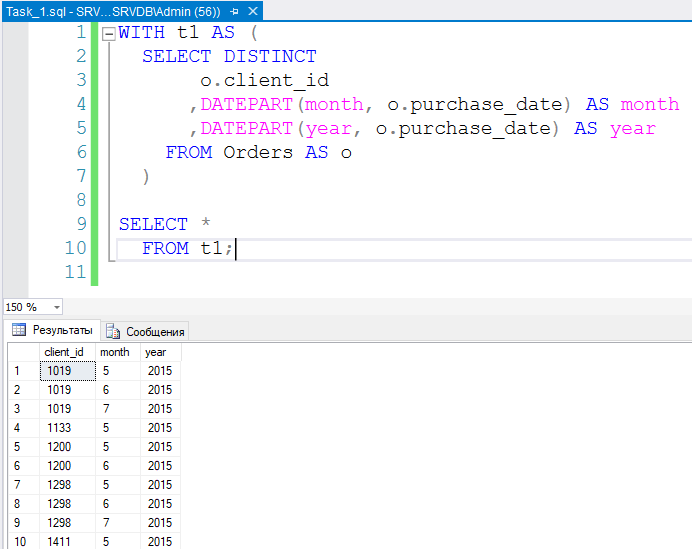
***

Готово, теперь для каждой торговой точки единожды указан месяц и год, когда происходила закупка.

**Шаг 2**

Теперь необходимо определить новые торговые точки. Для этого пронумеруем в хронологическом порядке факты закупок в месяц для каждой точки:

***
    WITH t1 AS (
        SELECT DISTINCT
                 o.client_id
                ,DATEPART(month, o.purchase_date) AS month
                ,DATEPART(year, o.purchase_date) AS year
            FROM Orders AS o
        )

    SELECT
             t1.client_id
            ,t1.month
            ,t1.year
            ,ROW_NUMBER() OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS rn
        FROM t1;
***

Результат выполнения:

***
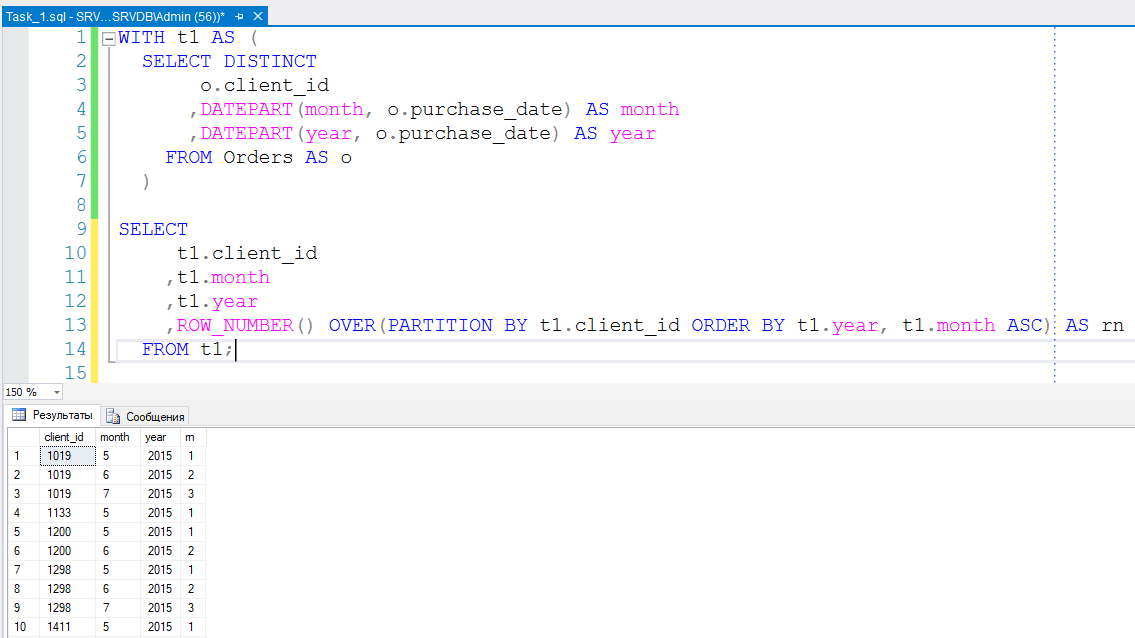
***

Порядковый номер "rn" указывает, какой по счёту месяц точка совершает закупки.

**Шаг 3**

Очевидно, что для каждого месяца новыми точками будут являться те, у которых в этот месяц была первая закупка. То есть, порядковый номер "rn" должен быть равен единице. Доработаем запрос: добавим ещё одну CTE "t2".

***
    -- Initial CTE is to provide usable representation.
    WITH t1 AS (
        SELECT DISTINCT
                 o.client_id
                ,DATEPART(month, o.purchase_date) AS month
                ,DATEPART(year, o.purchase_date) AS year
            FROM Orders AS o
        ),

    -- Second CTE is to ranking by date.
    t2 AS (
        SELECT
                 t1.client_id
                ,t1.month
                ,t1.year
                ,ROW_NUMBER() OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS rn
            FROM t1
        )

    -- Main query with only newest trade points.
    SELECT
             t2.client_id
            ,t2.month
            ,t2.year
        FROM t2
        WHERE t2.rn = 1;
***

Результат выполнения:

***
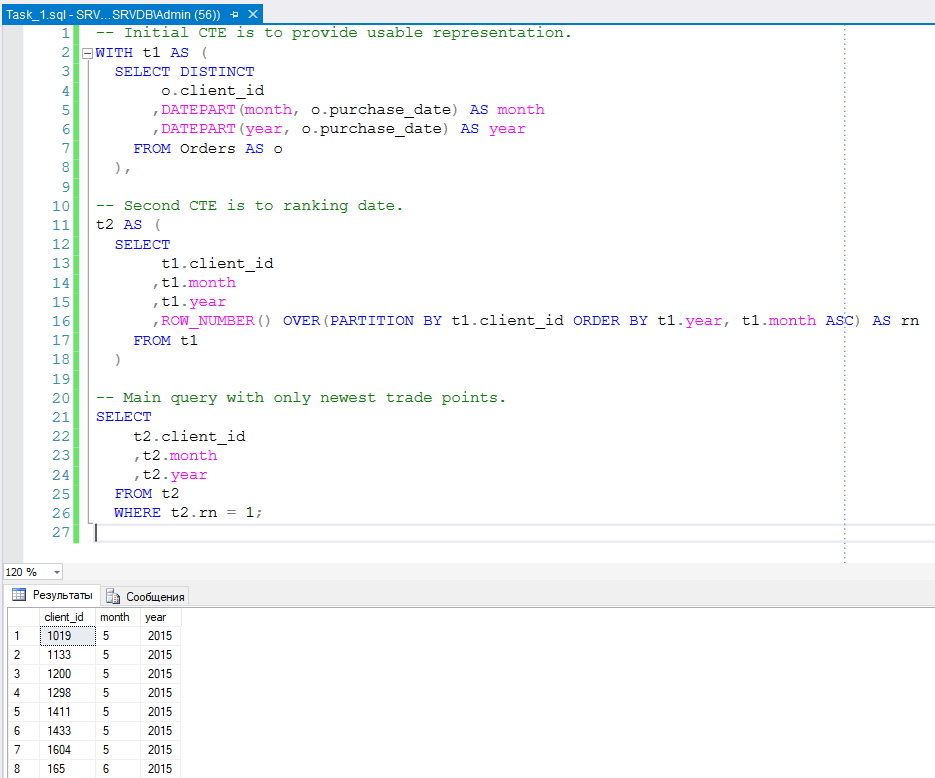
***

Задача выполнена. В результирующем запросе для каждого месяца представлены только новые точки.

Также основную часть запроса можно было бы реализовать при помощи оператора <code>TOP</code>:

***
    -- Main query with only newest trade points.
    SELECT TOP 1 WITH TIES
             t2.client_id
            ,t2.month
            ,t2.year
        FROM t2
        ORDER BY t2.rn;
***

## 2. Решение задачи 2 - "Торговые точки, сделавшие заказ в прошлом месяце и в этом" <a id='task_2'></a>

**Шаг 1**

Наиболее простым для понимания способом решения данной задачи является использование оператора <code>LAG</code>.
Используя CTE "t1" из п. 1, получим для каждой торговой точки месяц и год предыдущей закупки.

***
    -- Initial CTE is to provide usable representation.
    WITH t1 AS (
        SELECT DISTINCT
                 o.client_id
                ,DATEPART(month, o.purchase_date) AS month
                ,DATEPART(year, o.purchase_date) AS year
            FROM Orders AS o
        )

    SELECT
             t1.client_id
            ,t1.month
            ,t1.year
            ,LAG(t1.month) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS month_lag
            ,LAG(t1.year) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS year_lag
        FROM t1;
***

Результат выполнения:

***
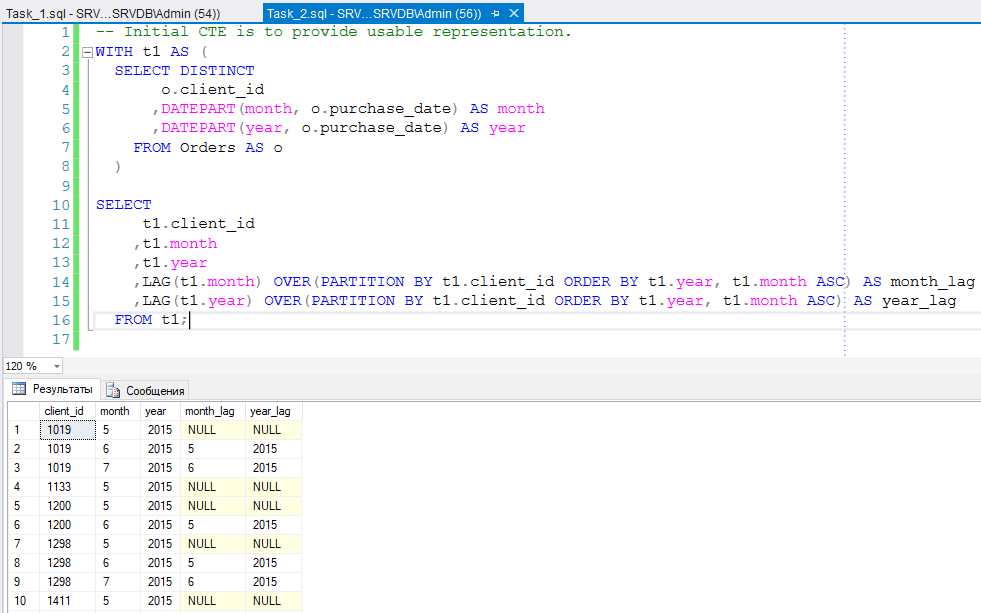
***

Точки, у которых предыдущий месяц и год не имеют значений (NULL), являются новыми для данного месяца - то есть, это ещё один вариант решения первого задания.

**Шаг 2**

Для решения второго задания необходимо отфильтровать записи согласно двум вариантам:
1. В рамках одного года, текущий месяц должен отличаться от предыдущего на единицу.
2. В рамках разных годов, года должны отличаться на единицу, текущий месяц должен быть равен 1, а предыдущий - 12.

Добавим ещё CTE "t2" для выполнения фильтрации.

***
    -- Initial CTE is to provide usable representation.
    WITH t1 AS (
        SELECT DISTINCT
                 o.client_id
                ,DATEPART(month, o.purchase_date) AS month
                ,DATEPART(year, o.purchase_date) AS year
            FROM Orders AS o
        ),

    t2 AS (
        SELECT
                 t1.client_id
                ,t1.month
                ,t1.year
                ,LAG(t1.month) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS month_lag
                ,LAG(t1.year) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS year_lag
            FROM t1
        )

    SELECT *
        FROM t2
        WHERE
            (t2.year = t2.year_lag AND t2.month = t2.month_lag + 1)
            OR (t2.year = t2.year_lag + 1 AND t2.month = 1 AND t2.month_lag = 12);
***

Результат выполнения:

***
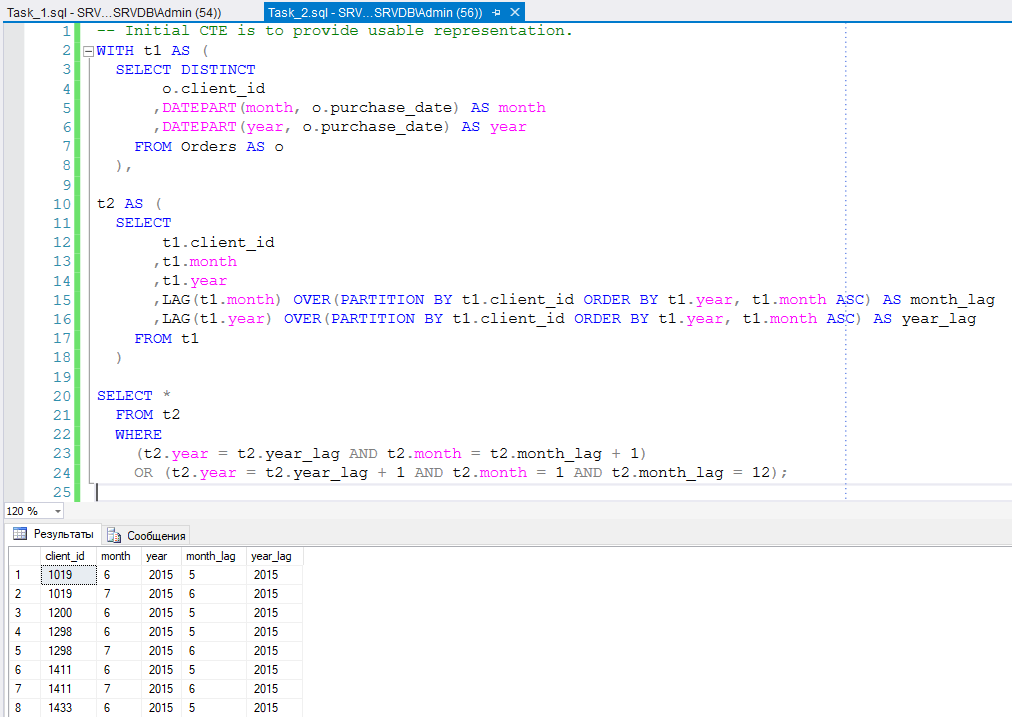
***

В результирующем запросе для каждого месяца остались только те торговые точки, которые делали заказ и в текущем месяце, и в прошлом.

**Шаг 3**

Добавим комментарии и настроим вывод необходимых полей.

***
-- Initial CTE is to provide usable representation.
WITH t1 AS (
	SELECT DISTINCT
			 o.client_id
			,DATEPART(month, o.purchase_date) AS month
			,DATEPART(year, o.purchase_date) AS year
		FROM Orders AS o
	),

-- Second CTE is to define previous date.
t2 AS (
	SELECT
			 t1.client_id
			,t1.month
			,t1.year
			,LAG(t1.month) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS month_lag
			,LAG(t1.year) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS year_lag
		FROM t1
	)

-- Main query with only that points which had previous month activity.
SELECT
		 t2.client_id
		,t2.month
		,t2.year
	FROM t2
	WHERE
		(t2.year = t2.year_lag AND t2.month = t2.month_lag + 1)
		OR (t2.year = t2.year_lag + 1 AND t2.month = 1 AND t2.month_lag = 12);
***

Результат выполнения:

***
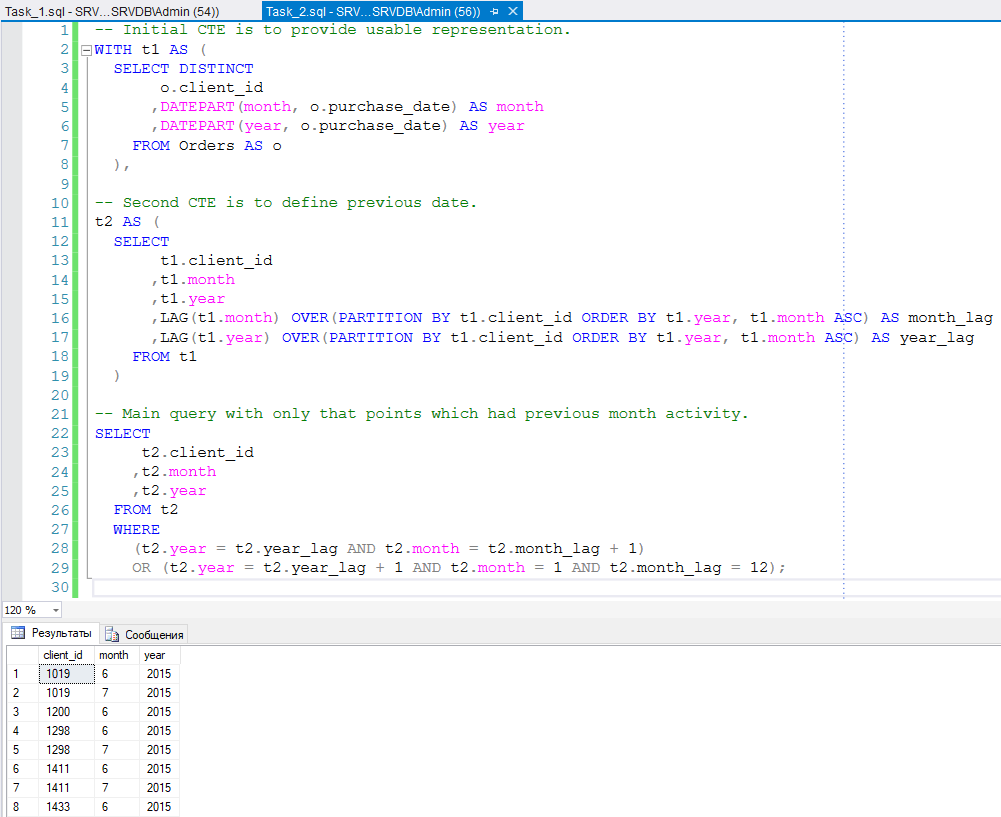
***

Задача выполнена. В результирующем запросе для каждого месяца представлены только те точки, которые совершали заказ в предыдущем месяце.

## 3. Решение задачи 3 - "Торговые точки, которые когда-то что-то заказали(только не в прошлом месяце) и вернувшиеся." <a id='task_3'></a>

Для решения задачи можно воспользоваться наработками из п. 2.

Отличия будут только в фильтрации в основной части запроса:
1. В течение одного года разница между заказами должна составлять более одного месяца.
2. При смене года не должен попадать переход декабрь-январь, то есть либо один месяц не должен быть равен декабрю, либо другой январю.
3. Разница между между годами должна составлять более одного года.

***
    -- Initial CTE is to provide usable representation.
    WITH t1 AS (
        SELECT DISTINCT
                 o.client_id
                ,DATEPART(month, o.purchase_date) AS month
                ,DATEPART(year, o.purchase_date) AS year
            FROM Orders AS o
        ),

    -- Second CTE is to define previous date.
    t2 AS (
        SELECT
                 t1.client_id
                ,t1.month
                ,t1.year
                ,LAG(t1.month) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS month_lag
                ,LAG(t1.year) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS year_lag
            FROM t1
        )

    -- Main query with only that points which didn't have previous month activity.
    SELECT
             t2.client_id
            ,t2.month
            ,t2.year
            ,t2.month_lag
            ,t2.year_lag
        FROM t2
        WHERE
            (t2.year = t2.year_lag AND t2.month > t2.month_lag + 1)
            OR (t2.year = t2.year_lag + 1 AND (t2.month <> 1 OR t2.month_lag <> 12))
            OR (t2.year > t2.year_lag + 1);
***

Результат выполнения:

***
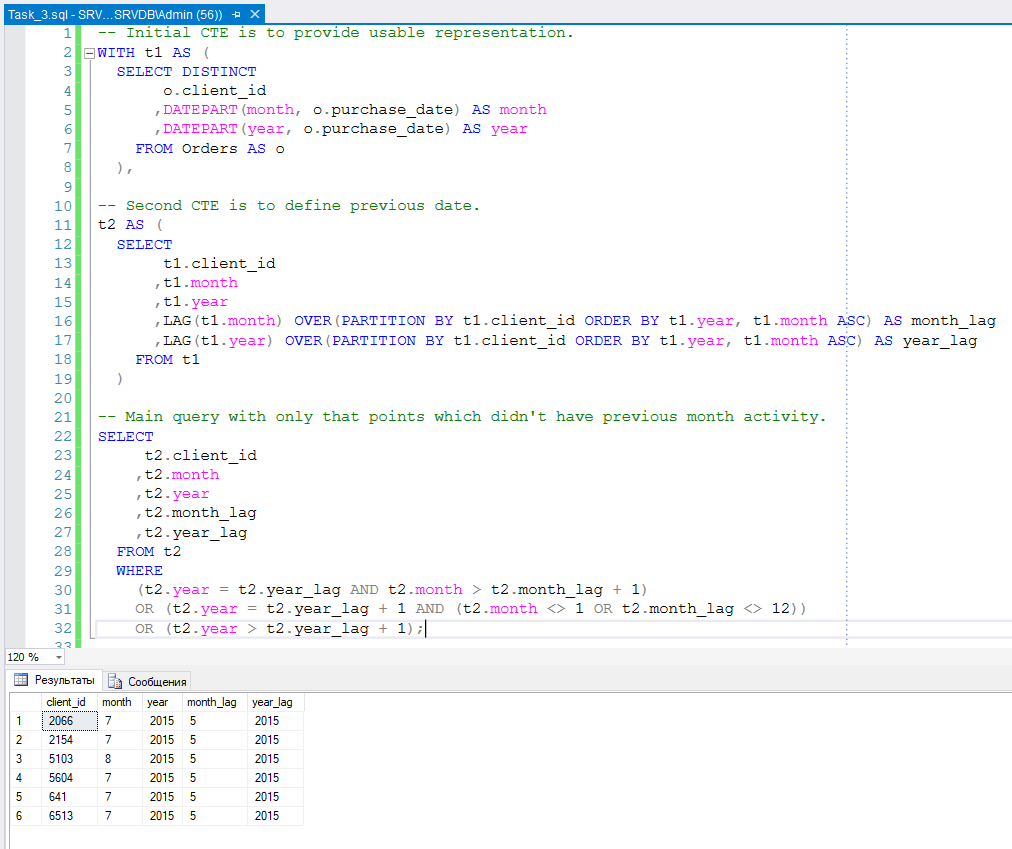
***

В результирующий запрос для каждого месяца попадают только те точки, которые имели историю заказов более месяца назад.

Настроим вывод необходимых полей.

***
    -- Initial CTE is to provide usable representation.
    WITH t1 AS (
        SELECT DISTINCT
                 o.client_id
                ,DATEPART(month, o.purchase_date) AS month
                ,DATEPART(year, o.purchase_date) AS year
            FROM Orders AS o
        ),

    -- Second CTE is to define previous date.
    t2 AS (
        SELECT
                 t1.client_id
                ,t1.month
                ,t1.year
                ,LAG(t1.month) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS month_lag
                ,LAG(t1.year) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS year_lag
            FROM t1
        )

    -- Main query with only that points which didn't have previous month activity.
    SELECT
             t2.client_id
            ,t2.month
            ,t2.year
        FROM t2
        WHERE
            (t2.year = t2.year_lag AND t2.month > t2.month_lag + 1)
            OR (t2.year = t2.year_lag + 1 AND (t2.month <> 1 OR t2.month_lag <> 12))
            OR (t2.year > t2.year_lag + 1);
***

Результат выполнения:

***
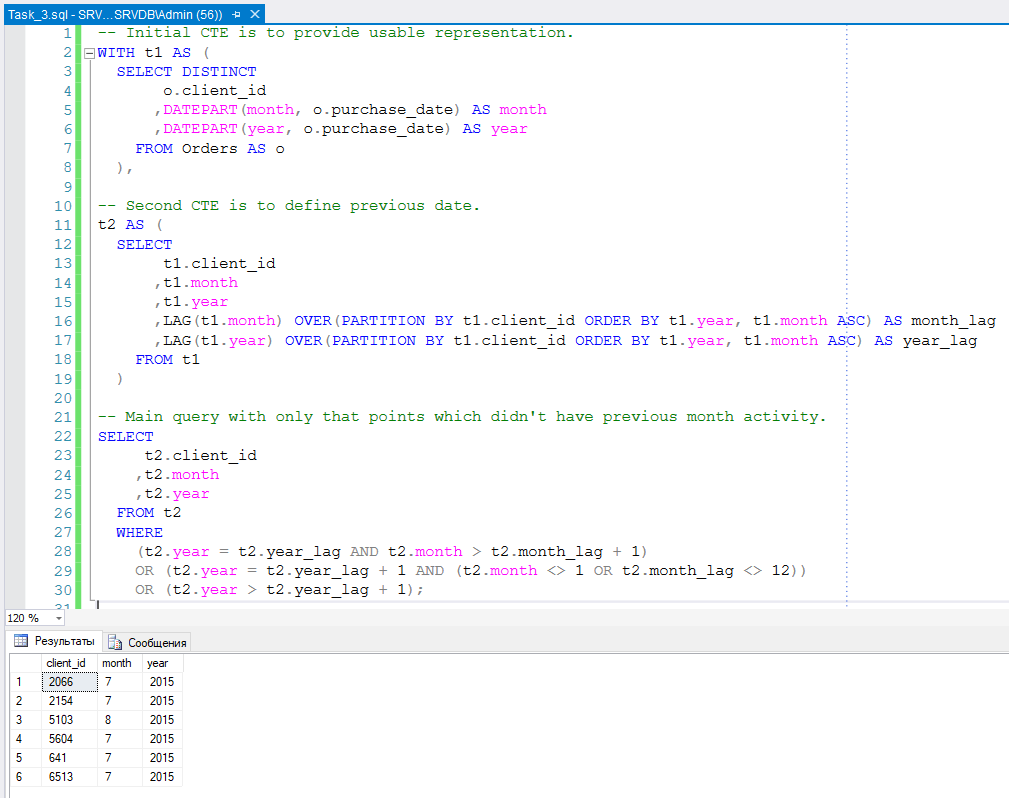
***

Задача выполнена.

## 4. Решение задачи 4 - "Торговые точки, отвалившиеся в этом месяце." <a id='task_4'></a>

**Шаг 1**

Для каждой точки рассмотрим следующую дату закупки относительно текущего месяца.

***
    -- Initial CTE is to provide usable representation.
    WITH t1 AS (
        SELECT DISTINCT
                 o.client_id
                ,DATEPART(month, o.purchase_date) AS month
                ,DATEPART(year, o.purchase_date) AS year
            FROM Orders AS o
        ),

    -- Second CTE is to define next date.
    t2 AS (
        SELECT
                 t1.client_id
                ,t1.month
                ,t1.year
                ,LEAD(t1.month) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS month_lead
                ,LEAD(t1.year) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS year_lead
            FROM t1
        )

    SELECT *
        FROM t2;
***

Результат выполнения:

***
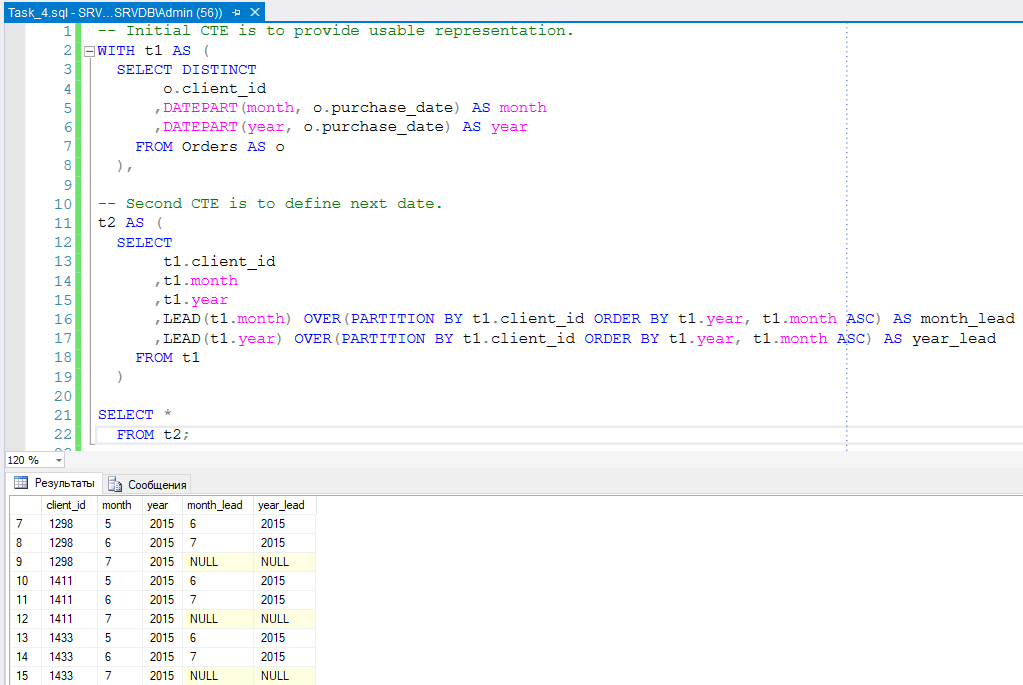
***

"Отвалившимися" точками можно считать те точки, которые либо не имеют следующей даты. Либо следующий месяц отличается более чем на единицу, то есть между рассматриваемым месяцем и месяцем следующей закупки были месяцы без активности данной торговой точки.

**Шаг 2**

Выполним фильтрацию "отвалившихся" точек с помощью следующих условий:
1. Либо дата следующей закупки неизвестна.
2. Либо, в рамках одного года, следующий месяц отличается более чем на 1.
3. Либо, при переходе на следующий год, не должно быть последовательности декабрь-январь.

***
    -- Initial CTE is to provide usable representation.
    WITH t1 AS (
        SELECT DISTINCT
                 o.client_id
                ,DATEPART(month, o.purchase_date) AS month
                ,DATEPART(year, o.purchase_date) AS year
            FROM Orders AS o
        ),

    -- Second CTE is to define next date.
    t2 AS (
        SELECT
                 t1.client_id
                ,t1.month
                ,t1.year
                ,LEAD(t1.month) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS month_lead
                ,LEAD(t1.year) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS year_lead
            FROM t1
        )

    SELECT *
        FROM t2
        WHERE
            t2.month_lead IS NULL
            OR (t2.year = t2.year_lead AND t2.month <> t2.month_lead - 1)
            OR (t2.year = t2.year_lead - 1 AND (t2.month <> 12 OR t2.month_lead <> 1));
***

Результат выполнения:

***
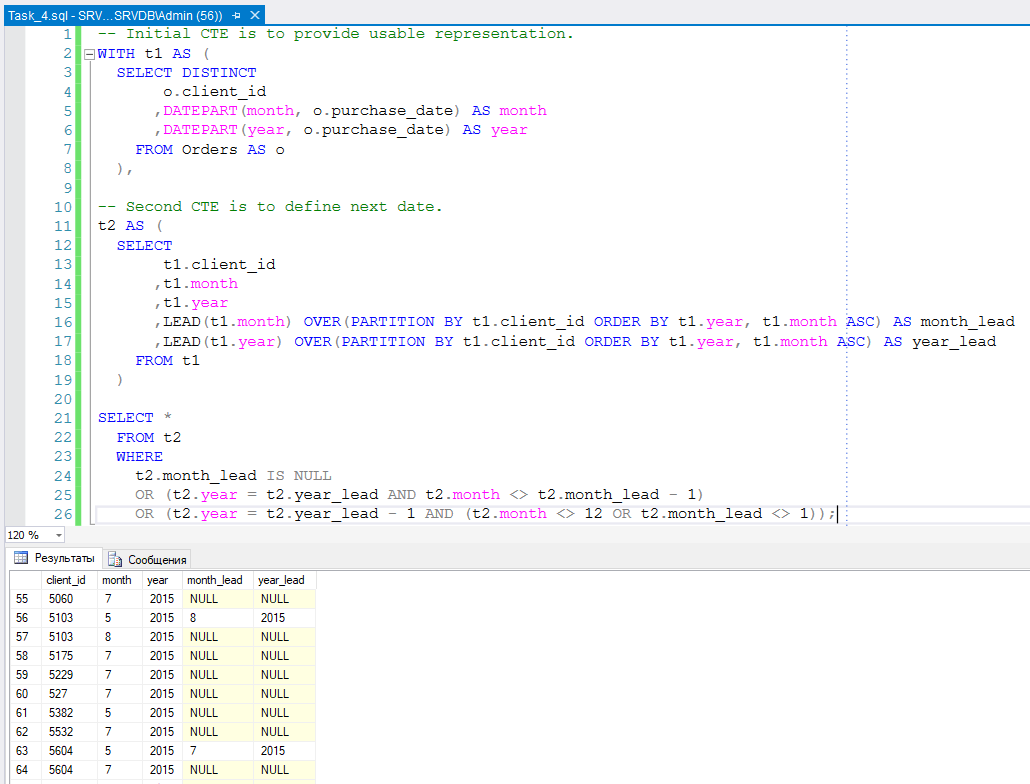
***

Написанный запрос позволил установить точки, которые не имеют активности в следующем месяце.

**Шаг 3**

Теперь для каждой точки, у которой нет активности в следующем месяце, необходимо сформировать дату следующего месяца. Так для каждого месяца мы получим точки, которые прекратили свою активность.

Дату следующего месяца, когда произошёл "отвал" точки, формируем следующим образом:
1. Последний месяц в году станет первым, год увеличится на 1.
2. Иначе месяц увеличится на 1, год не изменится.

***
    -- Initial CTE is to provide usable representation.
    WITH t1 AS (
        SELECT DISTINCT
                 o.client_id
                ,DATEPART(month, o.purchase_date) AS month
                ,DATEPART(year, o.purchase_date) AS year
            FROM Orders AS o
        ),

    -- Second CTE is to define next date.
    t2 AS (
        SELECT
                 t1.client_id
                ,t1.month
                ,t1.year
                ,LEAD(t1.month) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS month_lead
                ,LEAD(t1.year) OVER(PARTITION BY t1.client_id ORDER BY t1.year, t1.month ASC) AS year_lead
            FROM t1
        ),

    -- Third CTE is to define next month unactive points.
    t3 AS (
        SELECT *
            FROM t2
            WHERE
                t2.month_lead IS NULL
                OR (t2.year = t2.year_lead AND t2.month <> t2.month_lead - 1)
                OR (t2.year = t2.year_lead - 1 AND (t2.month <> 12 OR t2.month_lead <> 1))
        )

    SELECT
             t3.client_id
            ,IIF(t3.month = 12, 1, t3.month + 1) AS month
            ,IIF(t3.month = 12, t3.year + 1, t3.year) AS year
        FROM t3;
***

Результат выполнения:

***
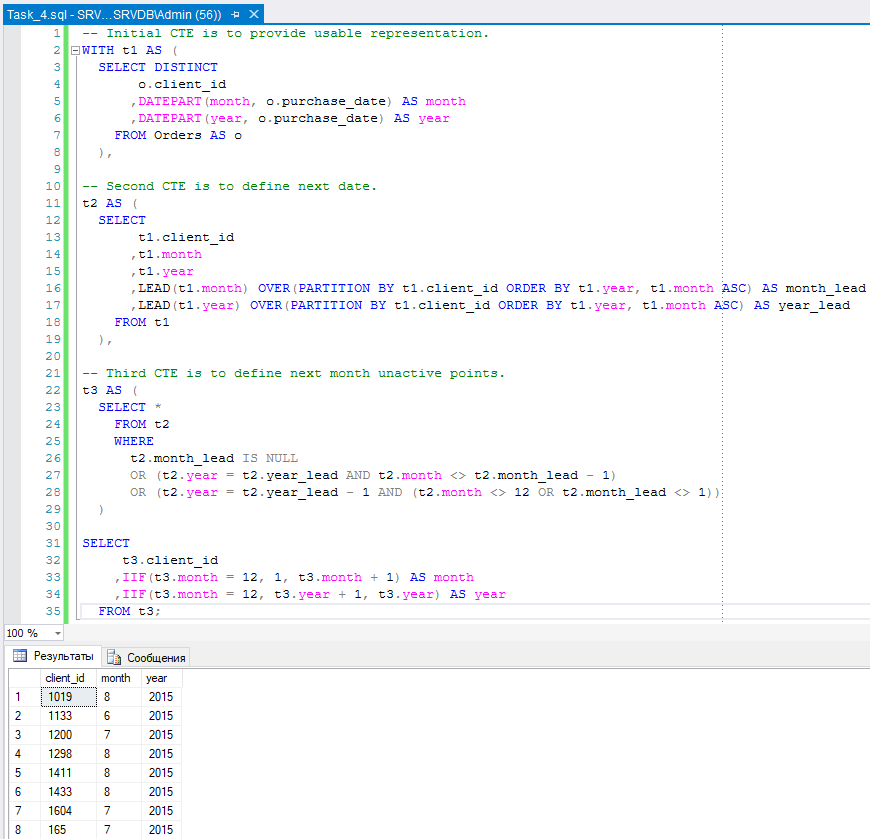
***

Задача выполнена, запрос выводит для каждого месяца торговые точки, которые перестали быть активными.

## 5. "Не обязательное задание: положить этот csv файл в SQL базу данных" <a id='task_5'></a>

Для выполнения тестового задания использовался <code>MS SQL Server 2016</code> + <code>Microsoft SQL Server Management Studio</code>.

Для импорта данных была использована встроенная утилита "Мастер импорта и экспорта SQL Server".

***
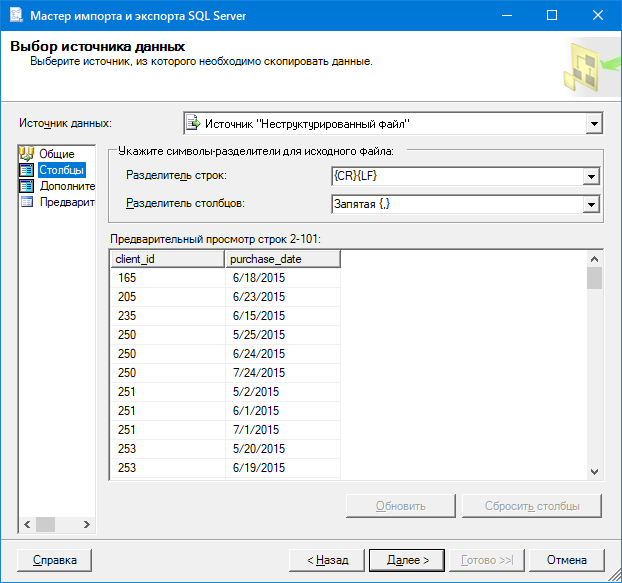
***

После импорта данные были предобработаны для удобства дальнейшего оперирования.

Следующий DML-запрос производил конвертацию столбца "purchase_date" из символьного типа в тип <code>DATE</code>.

***
    UPDATE [Orders]
    SET purchase_date = CONVERT(DATE, purchase_date, 101)
***